# Key findings and achievements

* Even though the majority of the volume of sales is concentrated in the UK, the most performing region in terms of average revenue is Asia. The ANOVA analysis shows that the **mean purchase value in the Asia/Pacific region is consistently and significantly higher** than the mean purchase value in the other regions. We can infer that the Asia/Pacific region is a potentially lucrative market with higher average purchase amounts than the other regions. Therefore, the store may want to consider investing more resources in this region to take advantage of this opportunity to increase volume of sales.
* By conducting a **market basket analysis** with a focus on the Asian market, we have identified groups of products that are commonly bought together. This has helped us uncover the specific preferences and purchasing patterns of this region. The firm could use this information to create bundled offers that combine these item sets and boost sales volume in the Asian market, ultimately leading to an increase in revenue.

___

# Introduction

The e-commerce industry has experienced significant growth in recent years, and online sales have become an increasingly important aspect of many businesses. Analyzing sales data can help businesses understand customer behavior and identify trends, which can then be used to improve their overall sales strategies and revenue. In this notebook, we will be analyzing a sales dataset from an e-commerce company to gain insights into their sales patterns and identify profitable opportunities.

Firstly, we will delve into analyzing the regional distribution of sales to evaluate the existence of untapped markets. By assessing the sales data across different regions, we will determine the areas where our products are in high demand and identify potential opportunities for expanding our market presence.

Secondly, we will conduct a market basket analysis to uncover correlations between products and provide recommendations for boosting sales. This will involve examining the patterns of product combinations that are frequently purchased together by customers. By identifying these relationships, we can optimize our marketing strategies to better meet the needs of our customers and ultimately increase revenue.

In [46]:
# dataframes
import numpy as np
import pandas as pd

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', grid=False)

# hypothesis testing
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# market basket analysis
from itertools import permutations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data

Let's begin by taking a look at the data at our disposal. The dataset is composed by the following original variables:

* **TransactionNo** (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* **Date** (numeric): the date when each transaction was generated.
* **ProductNo** (categorical): a five or six-digit unique character used to identify a specific product.
* **Product** (categorical): product/item name.
* **Price** (numeric): the price of each product per unit in pound sterling (£).
* **Quantity** (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* **CustomerNo** (categorical): a five-digit unique number that defines each customer.
* **Country** (categorical): name of the country where the customer resides.

In [47]:
df = pd.read_csv('../../data/sales.csv')

# We perform some operations to validate the type of variable, create an `Amount` column, 
# and subset the dataframe for an exact year of sales.

df['Date'] = pd.to_datetime(df['Date'])
df[['ProductNo', 'CustomerNo']] = df[['ProductNo', 'CustomerNo']].astype('object')

df['Amount'] = df['Quantity'] * df['Price']

df = df[(df['Date'] <= '2019-11-30') & (df['Quantity'] > 0)].copy()

display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 502753 entries, 25361 to 536324
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  502753 non-null  object        
 1   Date           502753 non-null  datetime64[ns]
 2   ProductNo      502753 non-null  object        
 3   ProductName    502753 non-null  object        
 4   Price          502753 non-null  float64       
 5   Quantity       502753 non-null  int64         
 6   CustomerNo     502752 non-null  object        
 7   Country        502753 non-null  object        
 8   Amount         502753 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 38.4+ MB


None

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Amount
25361,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432.0,United Kingdom,48.32
25362,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432.0,United Kingdom,24.16
25363,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432.0,United Kingdom,48.32
25364,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432.0,United Kingdom,60.40
25365,579522,2019-11-30,23240,Set Of 4 Knick Knack Tins Doily,6.19,6,14432.0,United Kingdom,37.14
...,...,...,...,...,...,...,...,...,...
536320,536585,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,2,17460.0,United Kingdom,40.90
536321,536590,2018-12-01,22776,Sweetheart 3 Tier Cake Stand,20.45,1,13065.0,United Kingdom,20.45
536322,536590,2018-12-01,22622,Box Of Vintage Alphabet Blocks,20.45,2,13065.0,United Kingdom,40.90
536323,536591,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,1,14606.0,United Kingdom,20.45


# Geographical sales analysis

When conducting a geographical analysis of sales, it is essential to consider both the average purchase value and sales volume to determine if there are any countries that offer promising opportunities. For instance, a country with a high average purchase value but low sales volume may indicate that it has untapped potential and should be targeted for further penetration. The average purchase value gives an indication of the buying power and willingness of customers to spend money, while sales volume reflects the market demand and potential for growth. A country with a high average purchase value and low sales volume could be a potential opportunity for businesses to capitalize on the untapped market potential by increasing their presence and promoting their products or services more effectively.

The analysis of the geographical spread of sales will be carried out at country level, national vs. international level, and finally regional level.

## Country level

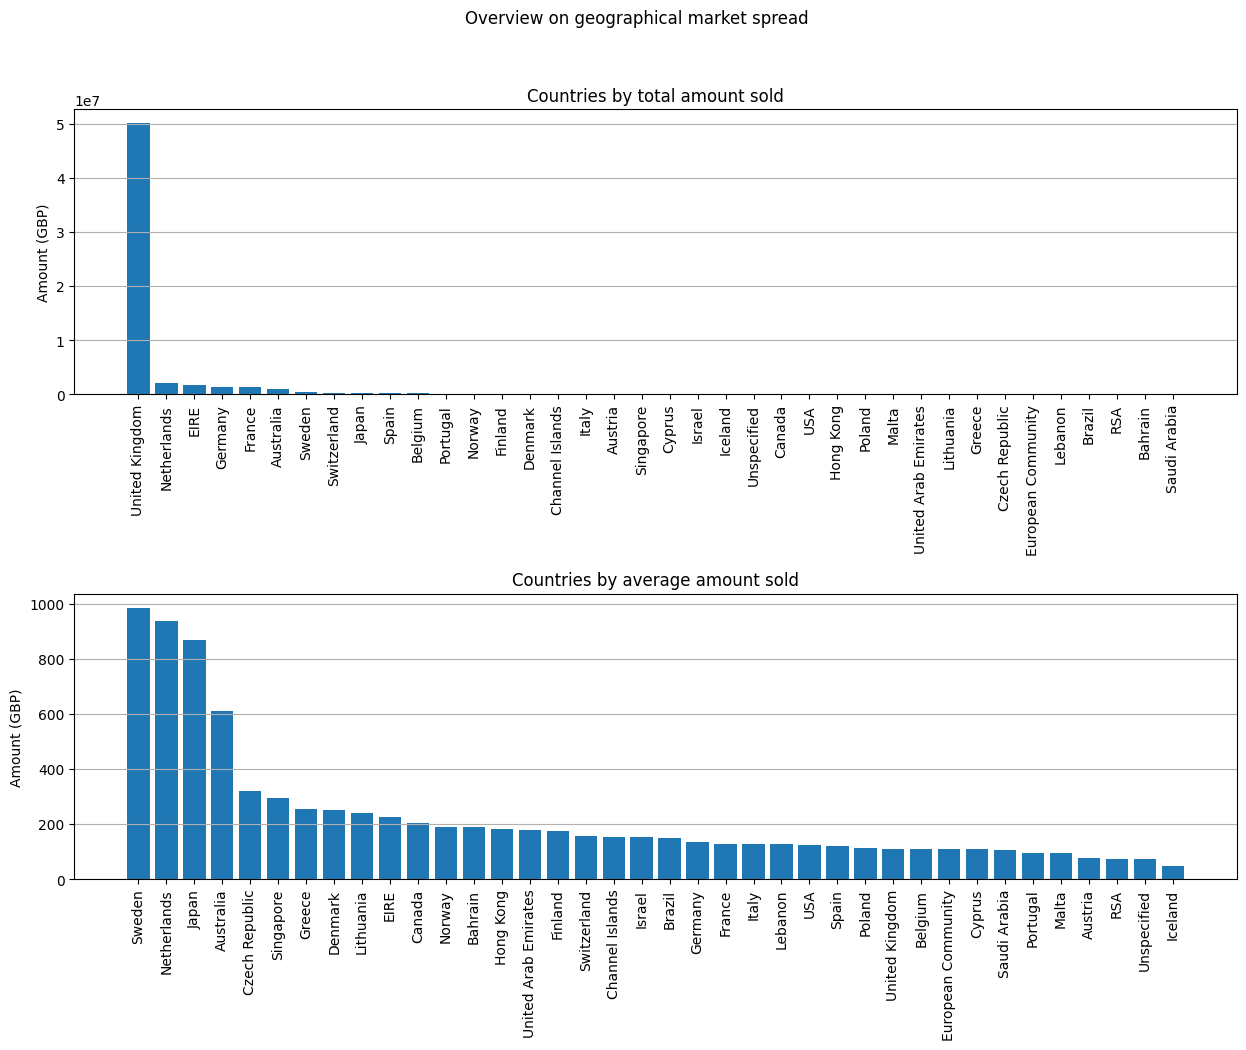

In [48]:
bycountry = df.groupby('Country').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean')
).sort_values('tot_amount', ascending=False)

# display(bycountry.head())

fig, ax = plt.subplots(2, figsize=(15,10))
ax[0].bar(bycountry.index, bycountry['tot_amount'])
ax[1].bar(bycountry.sort_values('mean_amount', ascending=False).index, bycountry.sort_values('mean_amount', ascending=False)['mean_amount'])
plt.setp(ax, xticks=bycountry.index, xticklabels=bycountry.index)
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="center")
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="center")

ax[0].set_ylabel("Amount (GBP)")
ax[1].set_ylabel("Amount (GBP)")
ax[0].set_title("Countries by total amount sold")
ax[1].set_title("Countries by average amount sold")
plt.suptitle("Overview on geographical market spread")
ax[0].grid(axis='y')
ax[1].grid(axis='y')
plt.subplots_adjust(hspace=0.7)

plt.show()

## National vs. international level

,tot_amount,mean_amount,n_inv,quantity
UKvsRoW,,,,
RoW,10258462.78,211.383944,1809,18.478900
UK,50192562.28,110.502027,17164,9.646163


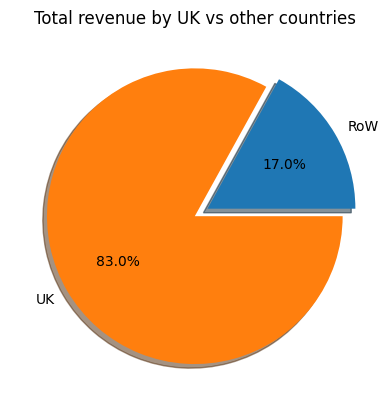

In [49]:
# Creating a column to differentiation between national vs. international sales
df['UKvsRoW'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'RoW')

byukvsrow = df.groupby('UKvsRoW').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean'),
    n_inv=('TransactionNo', 'nunique'),
    quantity=('Quantity', 'mean')
).sort_values('mean_amount', ascending=False)

display(byukvsrow)

plt.pie(byukvsrow['tot_amount'], labels=byukvsrow.index, autopct='%1.1f%%', explode=(0.1,0), shadow=True)
plt.title('Total revenue by UK vs other countries')
plt.show()

In [50]:
row_rev = df.loc[df['UKvsRoW'] == 'RoW', 'Amount']
uk_rev = df.loc[df['UKvsRoW'] == 'UK', 'Amount']

# We perform a two-sample ttest to check for statistically significant difference in average sales between national and international markets
ttest_ind(uk_rev, row_rev)

Ttest_indResult(statistic=-16.7279858606087, pvalue=8.524026769071223e-63)

> Even though the volume of sales of international customers accounts only for the 17.0%, a two-sample *ttest* demonstrates that the **average revenue generated abroad is significantly higher than the one generated in the UK**. This means that international markets for this business are potentially more lucrative than the national one and need to be exploited more.

## Regional level

,tot_amount,mean_amount,n_inv,quantity
Region,,,,
Asia Pacific,1380079.80,590.787586,92,51.083904
North America,59633.28,154.891636,11,13.503896
Middle East,76798.30,154.835282,16,12.661290
Europe,58892902.53,118.021612,18839,10.308538
RoW,8912.10,101.273864,2,8.000000
Unspecified,32699.05,73.152237,13,6.272931


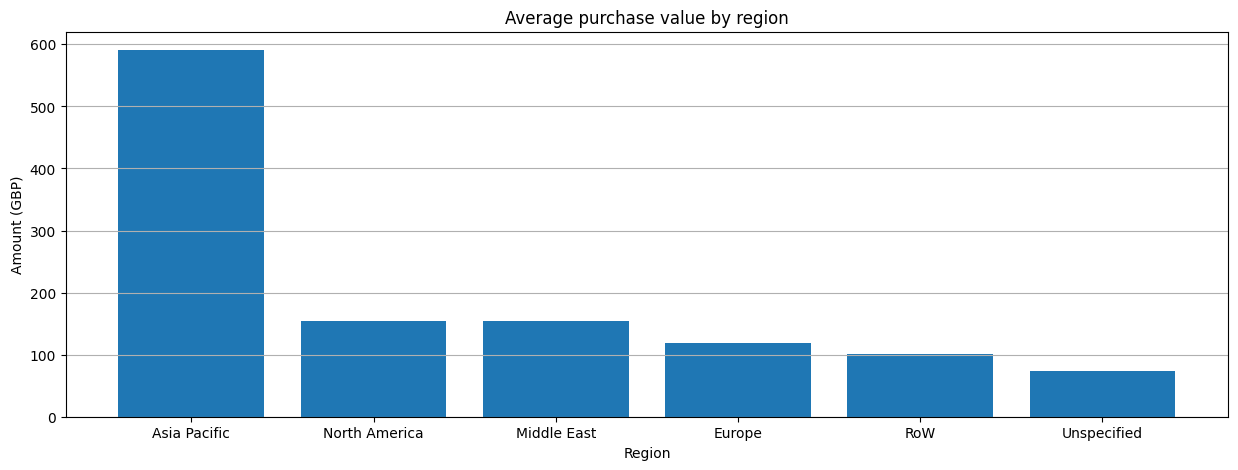

In [51]:
# Mapping regions
regions = {'Europe': ['Sweden', 'Denmark', 'Norway', 'Finland', 'Iceland', 'Netherlands', 'Belgium', 'France', 'Germany', 'Switzerland', 'Austria',
                      'Italy', 'Spain', 'Greece', 'Portugal', 'Malta', 'Cyprus', 'Czech Republic', 'Lithuania', 'Poland', 'United Kingdom', 'EIRE',
                      'Channel Islands', 'European Community'],
           'North America': ['USA', 'Canada'],
           'Middle East': ['Bahrain', 'United Arab Emirates', 'Israel', 'Lebanon', 'Saudi Arabia'],
           'Asia Pacific': ['Japan', 'Australia', 'Singapore', 'Hong Kong'],
           'RoW': ['Brazil', 'RSA'],
           'Unspecified': ['Unspecified']}

country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

df['Region'] = df['Country'].map(country_to_region)

byregion = df.groupby('Region').agg(
    tot_amount=('Amount', 'sum'),
    mean_amount=('Amount', 'mean'),
    n_inv=('TransactionNo', 'nunique'),
    quantity=('Quantity', 'mean')
).sort_values('mean_amount', ascending=False)

display(byregion.sort_values('mean_amount', ascending=False))

fig, ax1 = plt.subplots(figsize=(15,5))
ax1 = plt.bar(byregion.index, byregion['mean_amount'])
plt.title("Average purchase value by region")
plt.ylabel('Amount (GBP)')
plt.xlabel('Region')
plt.grid(axis='y')
plt.show()

In [52]:
f_value, p_value = f_oneway(
    df.loc[df['Region'] == 'Asia Pacific', 'Amount'],
    df.loc[df['Region'] == 'North America', 'Amount'],
    df.loc[df['Region'] == 'Middle East', 'Amount'],
    df.loc[df['Region'] == 'Europe', 'Amount'],
    df.loc[df['Region'] == 'RoW', 'Amount'])
print(f'ANOVA F-value: {f_value:.2f}')
print(f'ANOVA p-value: {p_value:.4f}')
tukey_df = df.filter(items=['Amount', 'Region']).dropna()
print(pairwise_tukeyhsd(tukey_df['Amount'], tukey_df['Region']))

ANOVA F-value: 81.58
ANOVA p-value: 0.0000
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
 Asia Pacific        Europe  -472.766    0.0 -547.3921 -398.1398   True
 Asia Pacific   Middle East -435.9523    0.0  -613.855 -258.0496   True
 Asia Pacific North America -435.8959    0.0 -633.8256 -237.9663   True
 Asia Pacific           RoW -489.5137 0.0048 -880.2663  -98.7612   True
 Asia Pacific   Unspecified -517.6353    0.0 -703.4071 -331.8636   True
       Europe   Middle East   36.8137 0.9872  -124.841  198.4683  False
       Europe North America     36.87 0.9928 -146.5938  220.3338  False
       Europe           RoW  -16.7477    1.0 -400.3757  366.8802  False
       Europe   Unspecified  -44.8694 0.9754 -215.1456  125.4068  False
  Middle East North America    0.0564    1.0 -244.3599  244.4726  False
  Middle East        

> We can observe from both the bar plot and the ANOVA analysis that the **mean purchase value in the Asia/Pacific region is consistently and significantly higher** than the mean purchase value in the other regions. Based on this important information, we can infer that the Asia/Pacific region is a potentially lucrative market with higher average purchase amounts than the other regions. Therefore, the store may want to consider investing more resources in this region to take advantage of this opportunity to increase volume of sales. The business can consider implementing targeted marketing strategies, such as advertising campaigns and promotions, that cater to the preferences and interests of the Asia/Pacific market. Additionally, it can explore expanding its product offerings to meet the specific demands of this region, or enhancing the quality of existing products to meet their higher standards. It may be useful to conduct further research and analysis to gain deeper insights into the preferences and behavior of customers in the Asia/Pacific region, and tailor sales strategies accordingly.

# Market basket analysis for the Asian market

Market basket analysis, specifically Apriori and association rules, can provide valuable insights into customer behavior and preferences that can be used to develop effective marketing strategies. By analyzing customer purchase patterns and identifying which products are commonly purchased together, businesses can create product bundles and promotions that cater to specific customer segments. For instance, if the analysis reveals that customers who purchase Product A are highly likely to also purchase Product B, the business can create a bundle that includes both products at a discounted price to increase sales.

The Asia/Pacific region has a consistently higher average purchase value than other regions, indicating a potential opportunity to increase sales and revenue in that particular market. By conducting basket analysis on this region, the business can gain further insights into the specific product preferences and purchasing habits of customers in this market. This information can then be used to create targeted marketing strategies, such as promotions and advertising campaigns, that appeal to the unique needs and interests of customers in the Asia/Pacific region.

First, we subset the dataframe to filter for the transactions happened in the Asian market and encode them in binary features (one-hot encoding). Then, with the Apriori algorithm, we group them together according to a minimum support of 0.05 and we filter them according to a minimum confidence level of 1.

The result is a dataframe containing frequently sold itemsets with a set a metrics for market basket analysis. These MBA metrics are commonly used in association rule mining, a data mining technique used to identify relationships and patterns among items in a dataset. Here's a brief explanation of each metric:

* **Antecedent support**: This refers to the proportion of transactions that contain the antecedent (or the "if" part of a rule). It is calculated as the number of transactions containing the antecedent divided by the total number of transactions.

* **Consequent support**: This refers to the proportion of transactions that contain the consequent (or the "then" part of a rule). It is calculated as the number of transactions containing the consequent divided by the total number of transactions.

* **Support**: This refers to the proportion of transactions that contain both the antecedent and the consequent. It is calculated as the number of transactions containing both the antecedent and the consequent divided by the total number of transactions.

* **Confidence**: This measures the strength of the association between the antecedent and the consequent. It is calculated as the support of the antecedent and consequent divided by the support of the antecedent. Confidence can range from 0 to 1, with higher values indicating stronger associations.

* **Lift**: This measures the degree to which the presence of the antecedent affects the likelihood of the consequent. It is calculated as the support of the antecedent and consequent divided by the product of the support of the antecedent and the support of the consequent. A lift value greater than 1 indicates a positive association between the antecedent and consequent, while a value less than 1 indicates a negative association.

* **Leverage**: This measures the difference between the observed frequency of the antecedent and consequent co-occurring and the frequency expected if they were independent. It is calculated as the support of the antecedent and consequent minus the product of the support of the antecedent and the support of the consequent. A positive leverage value indicates a positive association between the antecedent and consequent, while a negative value indicates a negative association.

* **Conviction**: This measures the degree of implication of the rule. It is calculated as the ratio of the support of the antecedent to the complement of the confidence. Conviction can range from 0 to infinity, with higher values indicating stronger implications.

In [53]:
# Subsetting for Asia/Pacific transactions
asian_market = df[df['Region'] == 'Asia Pacific']

# Converting transactions in a list of lists
transactions = asian_market.groupby('TransactionNo').apply(lambda x: list(x['ProductName'])).to_list()
encoder = TransactionEncoder().fit(transactions)
onehot = encoder.transform(transactions)
onehot = pd.DataFrame(onehot, columns=encoder.columns_)

# Selecting frequent itemsets with apriori algorythm
frequent_itemsets = apriori(onehot,
                            min_support = 0.05, 
                            max_len = 5, 
                            use_colnames = True)

print('Number of itemsets selected by the Apriori algorithm:', len(frequent_itemsets))

# Computing association rules for the frequent itemsets, and filtering by confidence == 1
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=1)

# Adding number of items in the itemsets
rules['n_antecedents'] = rules['antecedents'].apply(lambda x: len(x))
rules['n_consequents'] = rules['consequents'].apply(lambda x: len(x))
rules.sample(15, random_state=42)

Number of itemsets selected by the Apriori algorithm: 163


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,n_antecedents,n_consequents
37,"(Dolly Girl Lunch Box, Regency Cakestand 3 Tie...",(Roses Regency Teacup And Saucer),0.054348,0.097826,0.054348,1.0,10.222222,0.049031,inf,3,1
24,"(Roses Regency Teacup And Saucer, Dolly Girl L...",(Spaceboy Lunch Box),0.054348,0.108696,0.054348,1.0,9.200000,0.048440,inf,2,1
25,"(Roses Regency Teacup And Saucer, Spaceboy Lun...",(Dolly Girl Lunch Box),0.054348,0.097826,0.054348,1.0,10.222222,0.049031,inf,2,1
36,"(Roses Regency Teacup And Saucer, Dolly Girl L...",(Spaceboy Lunch Box),0.054348,0.108696,0.054348,1.0,9.200000,0.048440,inf,3,1
34,"(Roses Regency Teacup And Saucer, Dolly Girl L...",(Regency Cakestand 3 Tier),0.054348,0.086957,0.054348,1.0,11.500000,0.049622,inf,3,1
39,"(Roses Regency Teacup And Saucer, Dolly Girl L...","(Regency Cakestand 3 Tier, Spaceboy Lunch Box)",0.054348,0.054348,0.054348,1.0,18.400000,0.051394,inf,2,2
4,(Blue Polkadot Bowl),(Pink Polkadot Bowl),0.054348,0.054348,0.054348,1.0,18.400000,0.051394,inf,1,1
12,(Set Of 6 Snack Loaf Baking Cases),(Set Of 6 Tea Time Baking Cases),0.054348,0.054348,0.054348,1.0,18.400000,0.051394,inf,1,1
8,(Feltcraft Princess Lola Doll),(Feltcraft Princess Olivia Doll),0.054348,0.076087,0.054348,1.0,13.142857,0.050213,inf,1,1
3,(Blue Happy Birthday Bunting),(Pink Happy Birthday Bunting),0.054348,0.076087,0.054348,1.0,13.142857,0.050213,inf,1,1


> Upon examining the frequent itemsets, it becomes evident that most of them consist of identical items that are often purchased together, with only minor variations such as color or pattern. For instance, transactions may include items like Blue Polkadot Bowls and Pink Polkadot Bowls, Dolly Girl Lunch Boxes and Spaceboy Lunch Boxes, or Feltcraft Princess Lola Dolls and Feltcraft Princess Olivia Dolls.


## Bundle offers

Based on the observation that these items are frequently bought together, **it could be advantageous to offer them as bundles to customers**. The firm could offer convenience and value to customers while potentially increasing sales and revenue. For example, a bundle might include both the Blue Polkadot Bowl and the Pink Polkadot Bowl, or the Dolly Girl Lunch Box and the Spaceboy Lunch Box. This strategy can be an effective way to meet Asian customers needs while boosting profits for the retailer.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,n_antecedents,n_consequents
6,(Dolly Girl Lunch Box),(Spaceboy Lunch Box),0.097826,0.108696,0.097826,1.0,9.200000,0.087193,inf,1,1
0,(Alarm Clock Bakelike Red),(Alarm Clock Bakelike Green),0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf,1,1
1,(Alarm Clock Bakelike Green),(Alarm Clock Bakelike Red),0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf,1,1
2,(Basket Of Toadstools),(Set 3 Retrospot Tea/Coffee/Sugar),0.054348,0.076087,0.054348,1.0,13.142857,0.050213,inf,1,1
3,(Blue Happy Birthday Bunting),(Pink Happy Birthday Bunting),0.054348,0.076087,0.054348,1.0,13.142857,0.050213,inf,1,1
4,(Blue Polkadot Bowl),(Pink Polkadot Bowl),0.054348,0.054348,0.054348,1.0,18.400000,0.051394,inf,1,1
5,(Pink Polkadot Bowl),(Blue Polkadot Bowl),0.054348,0.054348,0.054348,1.0,18.400000,0.051394,inf,1,1
7,(Fairy Tale Cottage Night Light),(Red Toadstool Led Night Light),0.054348,0.119565,0.054348,1.0,8.363636,0.047850,inf,1,1
8,(Feltcraft Princess Lola Doll),(Feltcraft Princess Olivia Doll),0.054348,0.076087,0.054348,1.0,13.142857,0.050213,inf,1,1
9,(Green Regency Teacup And Saucer),(Roses Regency Teacup And Saucer),0.054348,0.097826,0.054348,1.0,10.222222,0.049031,inf,1,1


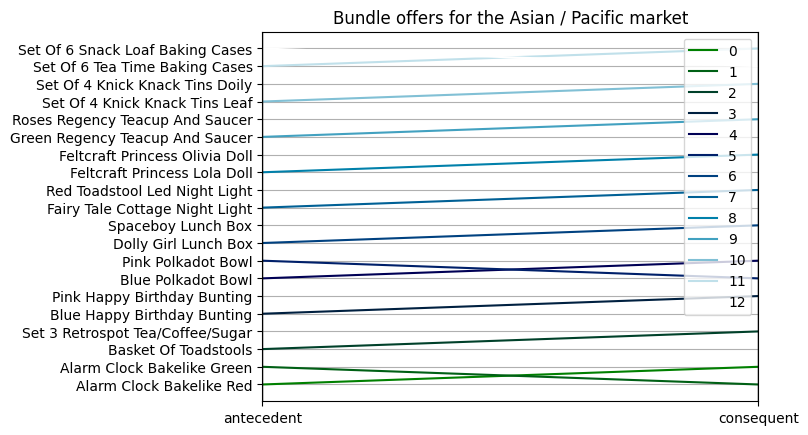

In [54]:
# Since we want to create bundle offers for single products, we filter for single items
rules = rules[(rules['n_antecedents'] == 1) & (rules['n_consequents'] == 1)]
display(rules.sort_values('support', ascending=False))

rules['antecedent'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequent'] = rules['consequents'].apply(lambda x: list(x)[0])
rules['rule'] = rules.index

coords = rules[['antecedent', 'consequent', 'rule']]

parallel_coordinates(coords, 'rule', colormap='ocean')
plt.title('Bundle offers for the Asian / Pacific market')
plt.show()

> The parallel coordinates plot visually highlights the bundles that were put together for the Asian market, and that the firm should offer on their e-commerce.

Offering bundles of products that are already sold together as frequent itemsets can be an effective marketing strategy for several reasons:

* Convenience: Bundling products that are frequently purchased together can provide customers with a convenient and streamlined shopping experience. Instead of having to search for each product individually, customers can purchase them together in a single transaction.

* Value proposition: Bundling products can create a compelling value proposition for customers. By offering a discount or special deal on a bundle of products, customers may be more likely to make a purchase than if they were buying each item individually.

* Increased sales: Bundling can also lead to increased sales by encouraging customers to purchase additional products that they may not have otherwise considered. For example, a customer who only intended to buy coffee may be enticed to buy a bundle that includes coffee, a mug, and a bag of coffee beans.

* Upselling opportunities: Bundling can also provide opportunities for upselling by encouraging customers to purchase a higher-value bundle that includes additional products or features.

In summary, while some products may already be sold together as frequent itemsets, bundling can provide additional value and convenience for customers, as well as opportunities for increased sales and upselling. By offering bundles, businesses can differentiate themselves from competitors and create a more compelling value proposition for their customers.